In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Loading the dataset
df = pd.read_csv('laptop_price.csv')

In [3]:
print(df.head())
print(df.info())
print(df.describe())

  Company      Product   TypeName  Inches                    ScreenResolution  \
0   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Macbook Air  Ultrabook    13.3                            1440x900   
2      HP       250 G6   Notebook    15.6                   Full HD 1920x1080   
3   Apple  MacBook Pro  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

  CPU_Company       CPU_Type  CPU_Frequency (GHz)  RAM (GB)  \
0       Intel        Core i5                  2.3         8   
1       Intel        Core i5                  1.8         8   
2       Intel  Core i5 7200U                  2.5         8   
3       Intel        Core i7                  2.7        16   
4       Intel        Core i5                  3.1         8   

                Memory GPU_Company                GPU_Type  OpSys  \
0            128GB SSD       Intel  Iris Plus Graphics 640  macOS

In [4]:
df.columns = df.columns.str.strip()  # remove extra spaces
df.columns = df.columns.str.replace('\xa0', ' ')  # remove hidden spaces
df.rename(columns={'Price (Euro)': 'Price'}, inplace=True)

In [5]:
df.columns

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution',
       'CPU_Company', 'CPU_Type', 'CPU_Frequency (GHz)', 'RAM (GB)', 'Memory',
       'GPU_Company', 'GPU_Type', 'OpSys', 'Weight (kg)', 'Price'],
      dtype='object')

In [6]:
# 2. Check missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM (GB)               0
Memory                 0
GPU_Company            0
GPU_Type               0
OpSys                  0
Weight (kg)            0
Price                  0
dtype: int64


In [7]:
# 3. Identify Numerical & Categorical Columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# Remove target from feature lists
target = "Price"
numerical_cols = [col for col in numerical_cols if col != target]


Numerical Columns: ['Inches', 'CPU_Frequency (GHz)', 'RAM (GB)', 'Weight (kg)', 'Price']
Categorical Columns: ['Company', 'Product', 'TypeName', 'ScreenResolution', 'CPU_Company', 'CPU_Type', 'Memory', 'GPU_Company', 'GPU_Type', 'OpSys']


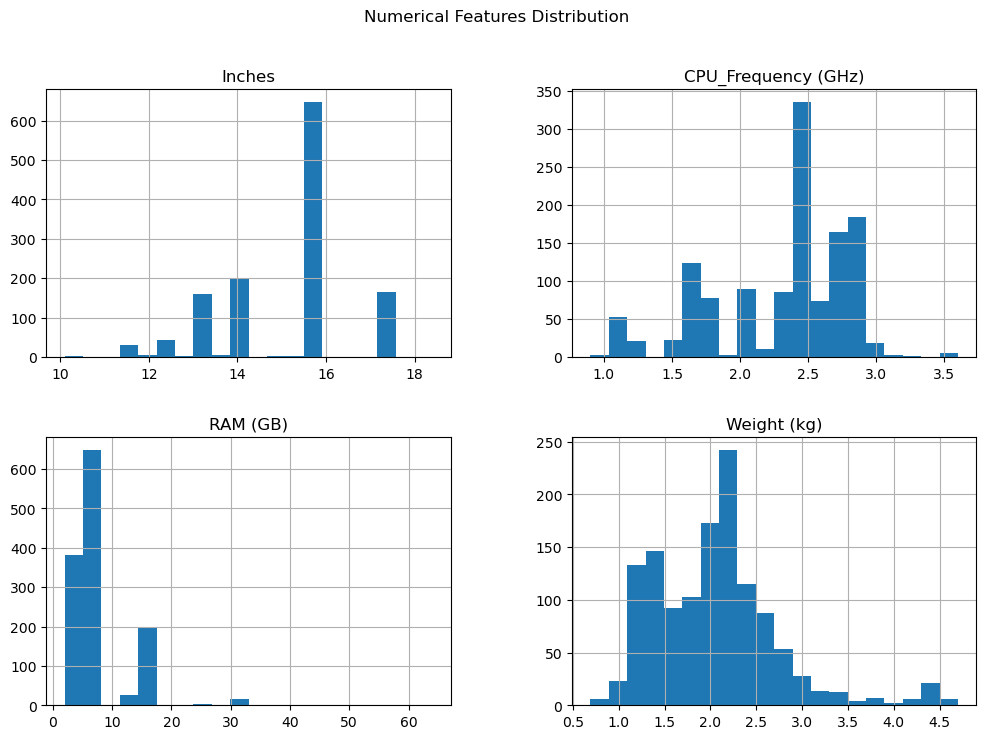

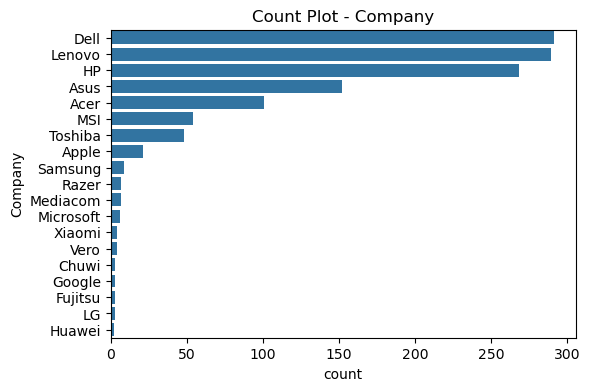

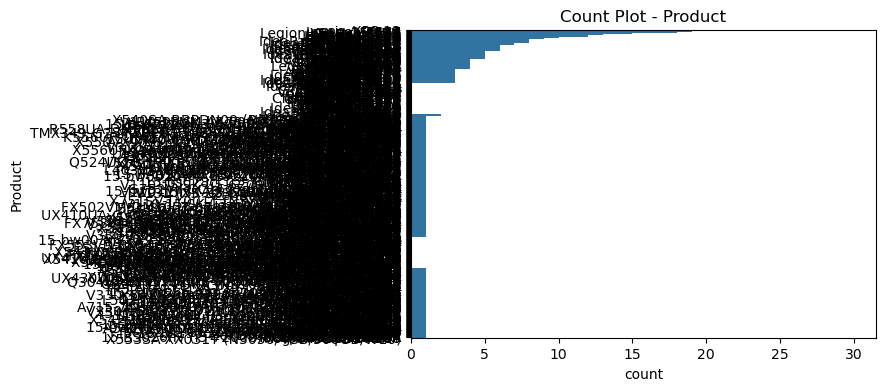

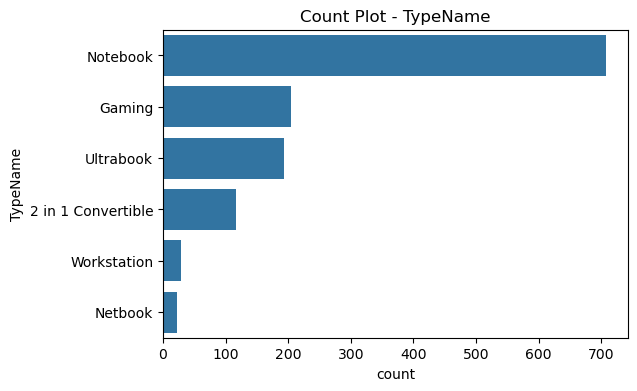

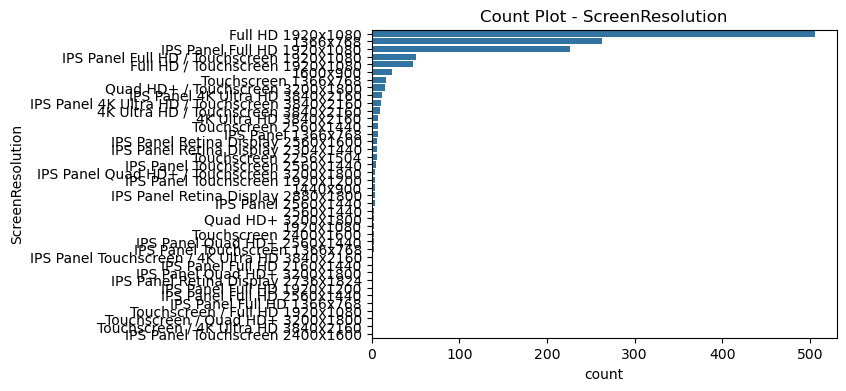

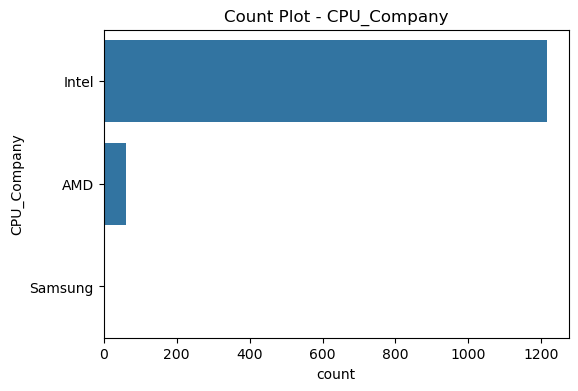

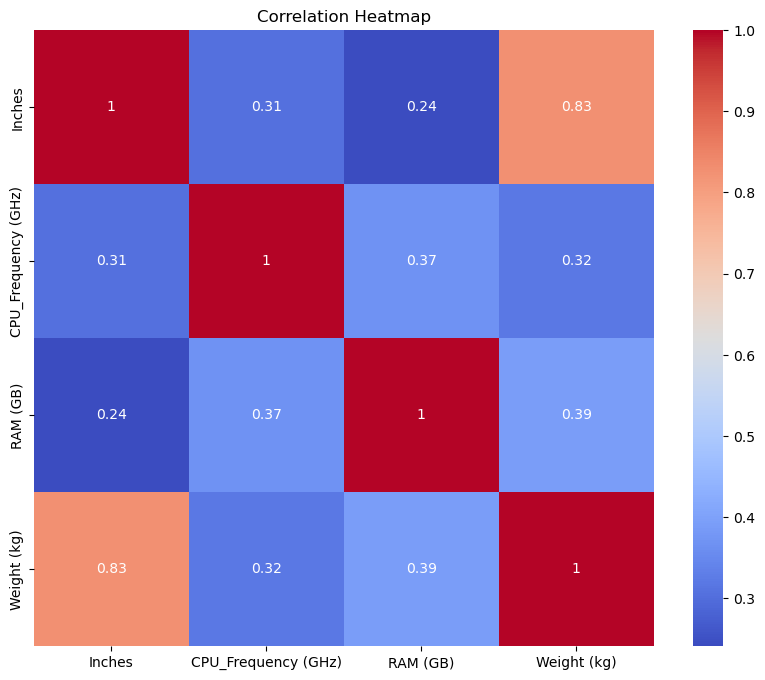

In [8]:
# 4. Visualizations
# 4.1 Distribution of numerical columns
df[numerical_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Numerical Features Distribution")
plt.show()

# 4.2 Count plot for categorical columns (only first few to avoid clutter)
for col in categorical_cols[:5]:
    plt.figure(figsize=(6, 4))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Count Plot - {col}")
    plt.show()

# 4.3 Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# 5. Train-Test Split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# 6. Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [11]:
# 8. Models Dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [12]:
# 9. Training and Evaluation
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }


In [13]:
# 10. Display Results
results_df = pd.DataFrame(results).T
print("\nModel Performance:\n", results_df)


Model Performance:
                           MAE            MSE        RMSE        R2
Linear Regression  204.567832   89942.409375  299.904000  0.818788
Decision Tree      232.203745  108720.908748  329.728538  0.780954
Random Forest      171.172803   64287.925406  253.550637  0.870476
Gradient Boosting  194.458289   66701.284050  258.265917  0.865614


In [15]:
# 12. Hyperparameter Tuning - Random Forest
rf_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20]
}

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=42))])

grid_search = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Params (Random Forest):", grid_search.best_params_)
print("Best Score (CV):", grid_search.best_score_)


Best Params (Random Forest): {'model__max_depth': 20, 'model__n_estimators': 100}
Best Score (CV): 0.8171622357378636


C:\Users\HP\AppData\Local\Temp\ipykernel_7228\553301852.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


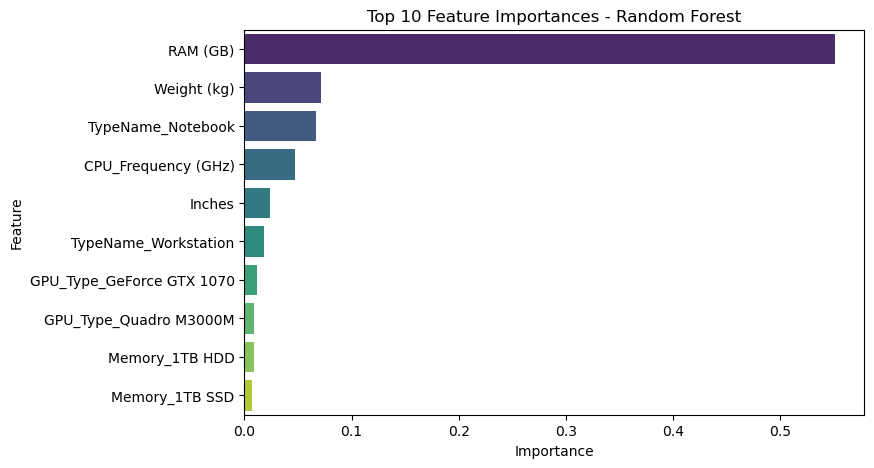

C:\Users\HP\AppData\Local\Temp\ipykernel_7228\553301852.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


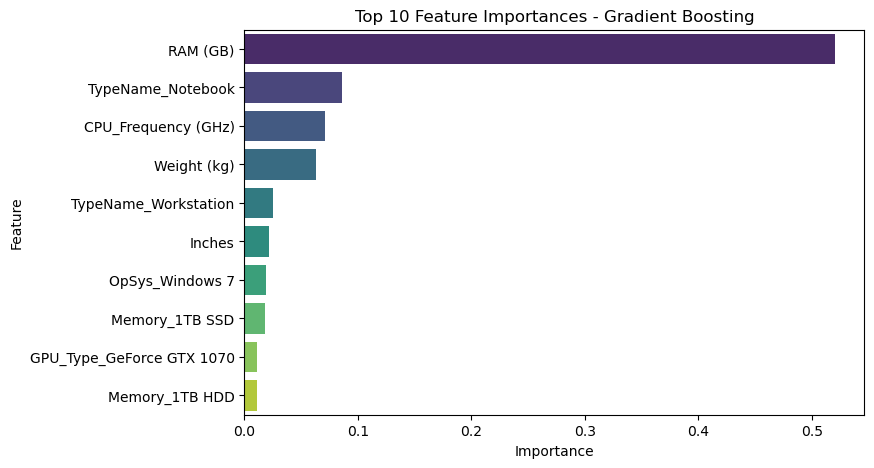

In [16]:
# 13. Feature Importance (Tree-Based Models)
def plot_feature_importance(model, model_name):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    # Get feature names after one-hot encoding
    feature_names = numerical_cols + list(pipe.named_steps['preprocessor']
                                          .transformers_[1][1]
                                          .get_feature_names_out(categorical_cols))
    importances = pipe.named_steps['model'].feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.show()

plot_feature_importance(RandomForestRegressor(random_state=42), "Random Forest")
plot_feature_importance(GradientBoostingRegressor(random_state=42), "Gradient Boosting")


In [17]:
# 14. Prediction Examples
sample_data = X_test.sample(5, random_state=42)
sample_pred = grid_search.predict(sample_data)
print("\nSample Predictions:\n")
for i, pred in enumerate(sample_pred):
    print(f"Laptop {i+1} → Predicted Price: €{pred:.2f}")


Sample Predictions:

Laptop 1 → Predicted Price: €1499.20
Laptop 2 → Predicted Price: €949.73
Laptop 3 → Predicted Price: €393.02
Laptop 4 → Predicted Price: €1624.61
Laptop 5 → Predicted Price: €1482.46
